<a href="https://colab.research.google.com/github/Monique14041980/FIAP-DATA-ANALYTICS/blob/main/Series_temporais_Ibovespa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Análise e Predição de Série Temporal IBOVESPA

Este notebook representa a entrega do **Tech Challenge da Fase 2**, Machine Learning e Séries Temporais, da Pós Graduação em Data Analytics da FIAP. A entrega consiste no desenvolvimento de uma análise de série temporal com o objetivo de prever o fechamento diário do índice da Bolsa Brasileira de Valores (IBOVESPA).

* A análise está dividida em:
 * Configuração e Coleta;
 * Os dados do IBOVESPA;
 * Inspeção e Tratamento;
 * EDA (Análise da ST);
 * Modelo e Avaliação.

* Observando os seguintes requisitos:
 * Modelo com o storytelling de ponta a ponta;
 * Justificativa da técnica usada;
 * Acurácia acima de 70%.


## Configuração






In [ ]:
# Instalando bibliotecas
!pip install statsmodels
!pip install statsforecast


In [ ]:
# Importando bibliotecas úteis
import os
import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsforecast import StatsForecast
from statsforecast.models import Naive, SeasonalNaive, SeasonalWindowAverage, AutoARIMA
from statsmodels.tsa.arima_model import ARIMA


## Os dados do IBOVESPA


Vamos utilizar a base de dados histórica diária da pontuação de fechamento do IBOVESPA (IBOV), disponível no <a href="https://br.investing.com/indices/bovespa-historical-data" class="external">Site da Investing</a>.

O IBOV é o principal indicador do mercado financeiro brasileiro, medindo o desempenho médio das ações negociadas na bolsa. Sua pontuação é calculada com base no valor de negociação das 70 empresas mais ativas de vários setores. Cada ponto equivale a 1 real. Um índice de 100 mil pontos representa um portfólio de 100 mil reais em ações. Pontos em alta indicam valorização das ações, enquanto pontos em baixa sinalizam desvalorização.

Esse data set contém 5 diferentes características como pontuação na abertura, fechamneto, máximo e mínimo e volume negociado. O histórico começou a ser registrado em 1968. Por eficiência, vamos usar dados coletados entre Agosto de 2005 à 2023.



In [ ]:
#Importando os dados
df = pd.read_csv('/content/Dados Históricos - Ibovespa.csv')

Vamos olhar as primeiras observações:

E, enxergar a evolução da pontuação de fechamento ao longo do tempo. Pra isso, de cara, vamos fazer um tratamento com o tipo de dado da coluna de data e trazer a data para o índice para facilitar a manipulação da série temporal:

In [ ]:
# Formatando a data e utilizando como índice
df.index = pd.to_datetime(df.Data, format = '%d.%m.%Y')
df = df.set_index(pd.to_datetime(df.index, format='%d.%m.%Y'))

df.head()

,Data,Último,Abertura,Máxima,Mínima,Vol.,Var%
Data,,,,,,,
2023-08-30,30.08.2023,117.535,118.404,118.841,117.471,"8,92M","-0,73%"
2023-08-29,29.08.2023,118.404,118.051,118.493,117.400,"9,63M","1,10%"
2023-08-28,28.08.2023,117.121,115.838,117.253,115.836,"9,60M","1,11%"
2023-08-25,25.08.2023,115.837,117.025,117.252,115.397,"9,21M","-1,02%"
2023-08-24,24.08.2023,117.026,118.135,118.136,116.848,"9,20M","-0,94%"


## Primeiras Visualizações

Vamos visualizar a série temporal pela primeira vez:

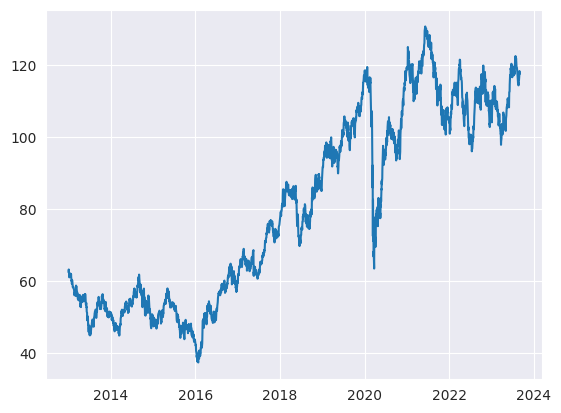

In [ ]:
plt.plot(df.index, df.Último)

Agora, vamos decompor a nossa série temporal pra entender melhor suas características e comportamento:

Para facilitar a decomposição utilizando o seasonal_decompose, vamos criar um df temporário apenas com a coluna que nos interessa, que vamos tentar fazer as predições: 'Último'

In [ ]:
# Criando o dataframe temporário
df_temp = df[['Último']]

In [ ]:
# Especificando a frequência
df_temp.index = pd.date_range(start='2005-08-30', periods=len(df), freq='D')

In [ ]:
# Performando a decomposição
resultados = seasonal_decompose(df_temp)

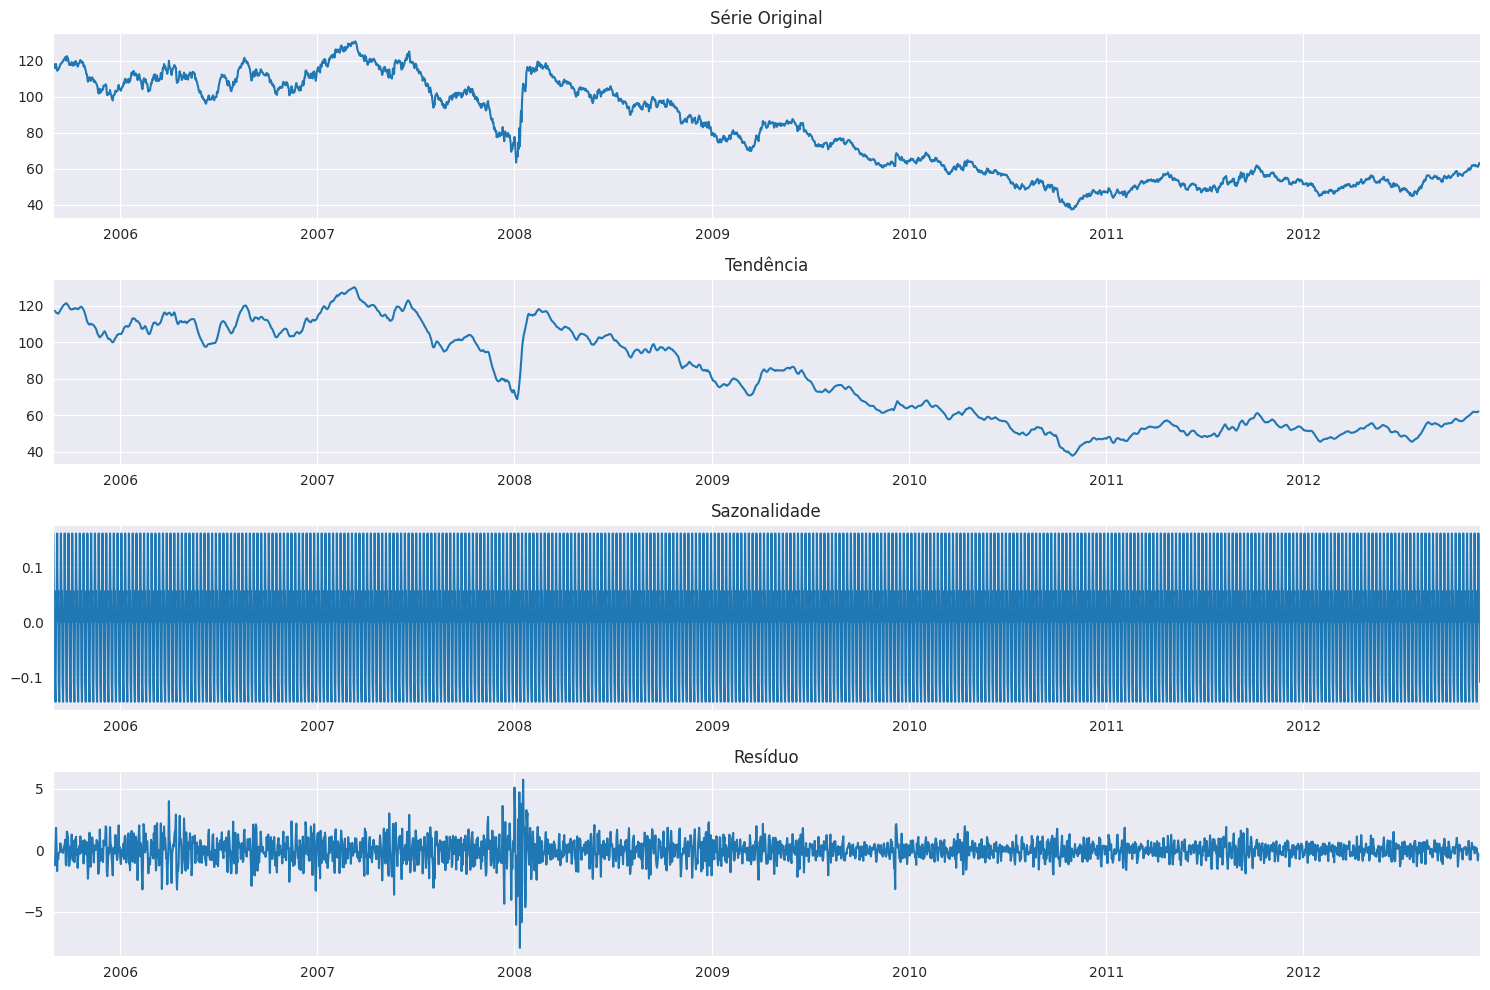

In [ ]:
# Plotando os componentes
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize = (15, 10))
resultados.observed.plot(ax=ax1)
ax1.set_title('Série Original')
resultados.trend.plot(ax=ax2)
ax2.set_title('Tendência')
resultados.seasonal.plot(ax=ax3)
ax3.set_title('Sazonalidade')
resultados.resid.plot(ax=ax4)
ax4.set_title('Resíduo')

plt.tight_layout()

##Inspeção e Tratamento


Antes de investigar sobre a estacionariedade da série, vamos entender mais a fundo o dataset a ser trabalhado. Nessa etapa, vamos aplicar uma EDA e realizar os tratamentos necessários.


In [ ]:
#Entendendo a dimensionalidade do dataframe
df.shape

(2643, 7)

In [ ]:
#Identificando os tipos de dados
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2643 entries, 2023-08-30 to 2013-01-02
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Data      2643 non-null   object 
 1   Último    2643 non-null   float64
 2   Abertura  2643 non-null   float64
 3   Máxima    2643 non-null   float64
 4   Mínima    2643 non-null   float64
 5   Vol.      2642 non-null   object 
 6   Var%      2643 non-null   object 
dtypes: float64(4), object(3)
memory usage: 165.2+ KB


In [ ]:
#Renomeando as colunas
colunas_renomeadas = {'Data': 'data', 'Último': 'ultimo', 'Abertura':'abertura','Máxima':'maxima', 'Mínima': 'minima', 'Vol.': 'volume', 'Var%':'variacao'}
df = df.rename(columns=colunas_renomeadas)

In [ ]:
#Entendendo se existe mais algum caractere representando unidade na coluna 'volume' além do "M"
df['volume'] = df['volume'].astype(str)
volume_concatenado = ''.join(df['volume'])
unique_characters = set(volume_concatenado)
print(unique_characters)

{'a', '6', '5', ',', '3', '1', '9', 'n', '8', '4', '7', 'K', 'M', '0', '2'}


In [ ]:
# Definindo uma função lambda para tratar as letras na variável numérica 'volume'
df['volume'] = df['volume'].apply(lambda x: float(x[:-1].replace(',', '.')) * 1000000 if x.endswith('M') else (float(x[:-1].replace(',', '.')) * 1000 if x.endswith('K') else float(x.replace(',', '.'))))


In [ ]:
# Remove '%' character and convert the 'percentage' column to float
df['variacao'] = df['variacao'].str.replace(',', '.').str.rstrip('%').astype(float)


In [ ]:
#Existem datas duplicadas?
df.duplicated().sum()

0

In [ ]:
#Existem dados nulos?
df.isnull().sum()

data        0
ultimo      0
abertura    0
maxima      0
minima      0
volume      1
variacao    0
dtype: int64

In [ ]:
#Encontrando linha em que o 'Vol.' é nulo
linha_nula = df[df['volume'].isnull()]
print(linha_nula)


                  data  ultimo  abertura  maxima  minima  volume  variacao
Data                                                                      
2016-02-10  10.02.2016  40.377    40.592  40.592   39.96     NaN     -0.53


Pesquisando em outra fonte da mesma base de dados, o volume realmente aparece zerado. Por isso, não me parece ser um problema no dataset analisado.

In [ ]:
#Analisando estatísticas do dataset
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
ultimo,2643.0,8.058764e+01,2.625959e+01,37.497,5.446300e+01,77.984,1.055440e+02,1.307760e+02
abertura,2643.0,8.056779e+01,2.625263e+01,37.501,5.445850e+01,77.928,1.055375e+02,1.307760e+02
maxima,2643.0,8.134519e+01,2.644128e+01,38.031,5.488950e+01,78.886,1.066650e+02,1.311900e+02
minima,2643.0,7.980097e+01,2.605225e+01,37.046,5.401350e+01,76.943,1.045195e+02,1.295260e+02
volume,2642.0,6.493128e+06,4.007764e+06,424320.000,3.502500e+06,4660000.000,9.352500e+06,2.603000e+07
variacao,2643.0,3.717745e-02,1.564344e+00,-14.780,-8.100000e-01,0.040,9.100000e-01,1.391000e+01


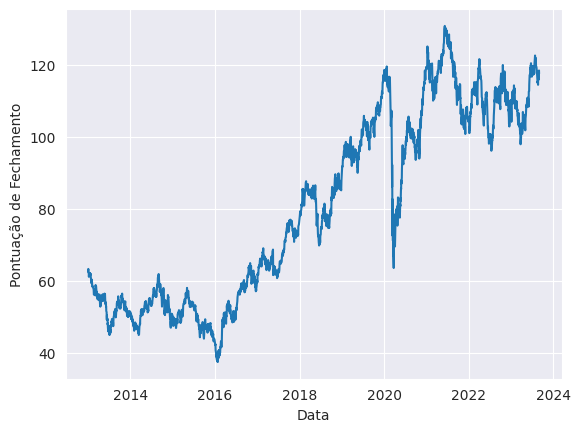

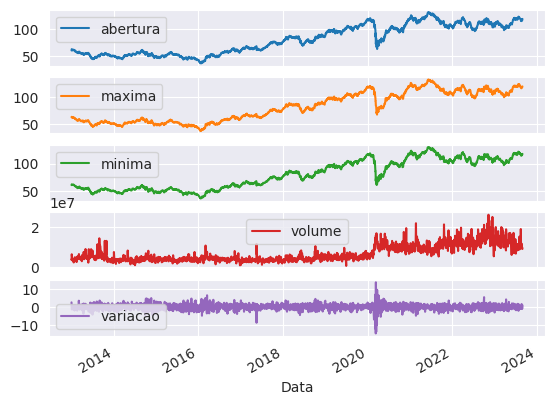

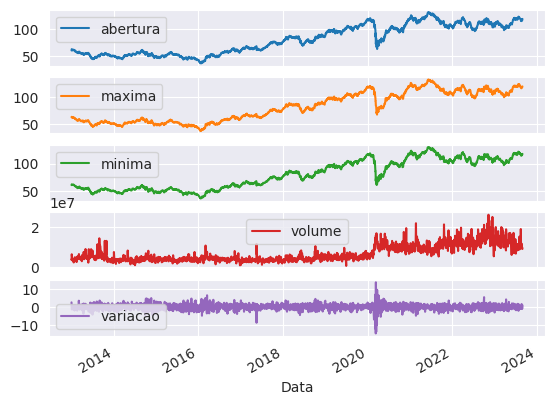

In [ ]:
# Visualizando demais características
plt.plot(df['ultimo'])
plt.xlabel('Data')
plt.ylabel('Pontuação de Fechamento')
plt.show()

plot_cols = ['abertura', 'maxima', 'minima', 'volume', 'variacao']

_ = df[plot_cols].plot(subplots=True)
plt.show()

_ = df[plot_cols][:].plot(subplots=True)
plt.show()

## EDA

Agora, vamos entender se a série é Estacionária, ou seja, aquela onde a média, variância e covariância são constantes. Essa característica será importante na criação do modelo. Pra isso, vamos aplicar o teste estatístico ADF (Dicky-Fuller Augmented).

In [ ]:
# Aplicando o teste ADF
# H0 = A série não é estacionária
# H1 = Rejeita H0 -> p-Valor < 0,005 -> rejeita-se com nível de confiança de 95%
# quanto menor, mais evidência contra a hipótese nula eu tenho

from statsmodels.tsa.stattools import adfuller

In [ ]:
sns.set_style('darkgrid')

In [ ]:
x = df.ultimo.values

In [ ]:
result = adfuller(x)

print("Teste ADF")
print(f"Teste Estatístico: {result[0]}")
print(f"P-Value: {result[1]}")
print(f"Valores Críticos: ")

for key, value in result[4].items():
  print(f"\t{key}:{value}")

Teste ADF
Teste Estatístico: -1.4948423626990341
P-Value: 0.5360611879150634
Valores Críticos: 
	1%:-3.432834129730111
	5%:-2.862637500037151
	10%:-2.56735423758412


Com um p-Value de 43% e um teste estatístico maior que os valores críticos, podemos afirmar que a série NÃO É ESTACIONÁRIA.

Vamos transformar em Estacionária pra poder aplicar os modelos. Pra isso, vamos remover a tendência aplicando algumas transformações nos dados.

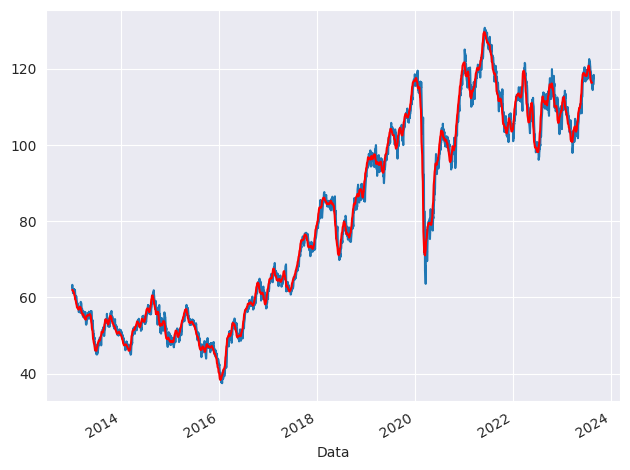

In [ ]:
# Aplicando média móvel em cima da linha da série original
ma = df.ultimo.rolling(12).mean()
f, ax = plt.subplots()
df.ultimo.plot(ax=ax, legend=False)
ma.plot(ax=ax, legend=False, color='r')
plt.tight_layout()

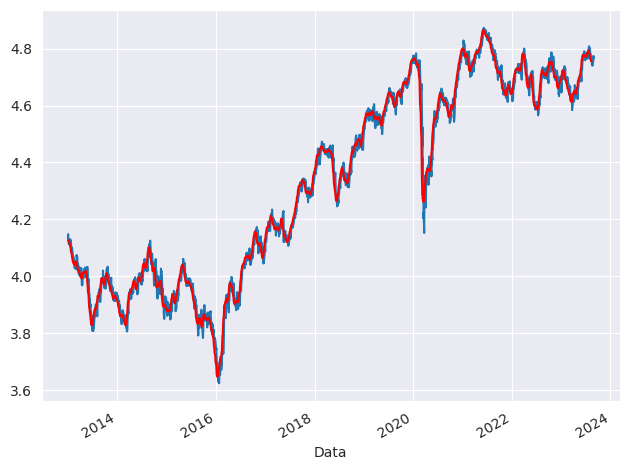

In [ ]:
# Aplicando log
df_log = np.log(df.ultimo)
ma_log = df_log.rolling(12).mean()

f, ax = plt.subplots()
df_log.plot(ax=ax, legend=False)
ma_log.plot(ax=ax, legend=False, color='r')
plt.tight_layout()

Percebe-se que, agora, apesar da curva não ter mudado muito visualmente, a série está representada em um eixo y diferente, na escala logarítmica.

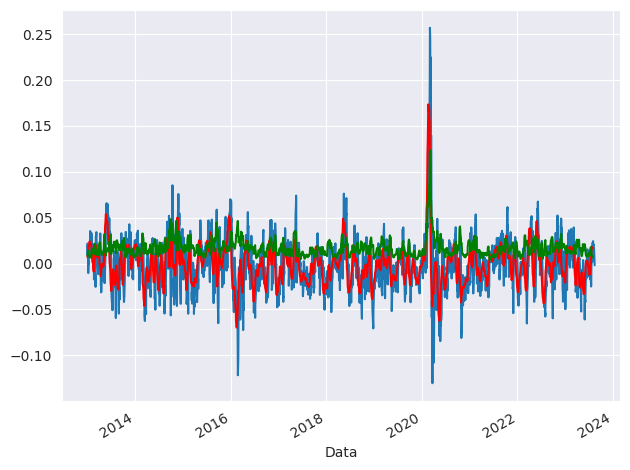

In [ ]:
# Subtraindo a média móvel
df_s = (df_log - ma_log).dropna()
ma_s = df_s.rolling(12).mean()
std = df_s.rolling(12).std()
f, ax = plt.subplots()
df_s.plot(ax=ax, legend=False)
ma_s.plot(ax=ax, legend=False, color='r')
std.plot(ax=ax, legend=False, color="g")
plt.tight_layout()

Agora, a série parece ser estacionária. Vamos verificar atráves do teste ADF.

In [ ]:
df_s.info()

<class 'pandas.core.series.Series'>
DatetimeIndex: 2632 entries, 2023-08-15 to 2013-01-02
Series name: ultimo
Non-Null Count  Dtype  
--------------  -----  
2632 non-null   float64
dtypes: float64(1)
memory usage: 41.1 KB


In [ ]:
# Repetindo o Teste ADF
x_s = df_s.values
result_s = adfuller(x_s)

print("Teste ADF")
print(f"Teste Estatístico: {result_s[0]}")
print(f"P-Value: {result_s[1]}")
print(f"Valores Críticos: ")

for key, value in result_s[4].items():
  print(f"\t{key}:{value}")

Teste ADF
Teste Estatístico: -13.207058233190804
P-Value: 1.065547177275691e-24
Valores Críticos: 
	1%:-3.4328445535976133
	5%:-2.8626421034231315
	10%:-2.5673566884539056


Pronto! Agora já podemos garantir o comportamento próximo do estacionário da série pois o teste estatístico está menor que os valores críticos e o p-Value está tendendo a zero, assim, rejeitamos a hipótese nula.

Agora, vamos suavizar ainda mais a série, ao trabalhar com diferenciação:

Teste ADF
Teste Estatístico: -15.86226605263947
P-Value: 9.182776030798119e-29
	1%:-3.4328627660143476
	5%:-2.86265014634789
	10%:-2.567360970560822


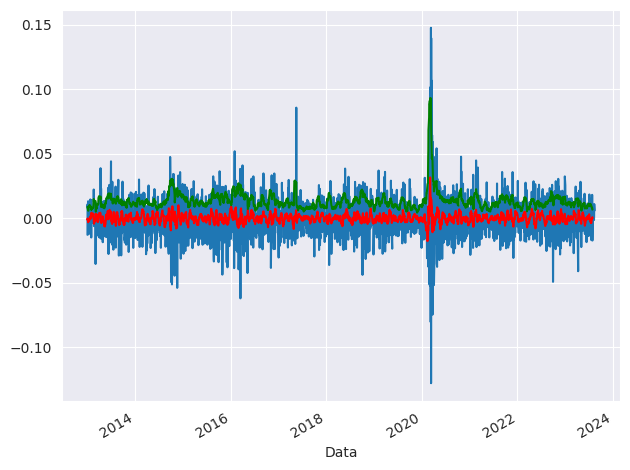

In [ ]:
#Desfazendo o log, aplicando diferenciação
df_diff = df_s.diff(1)
ma_diff = df_diff.rolling(12).mean()
std_diff = df_diff.rolling(12).std()

f, ax = plt.subplots()
df_diff.plot(ax=ax, legend=False)
ma_diff.plot(ax=ax, legend=False, color='r')
std_diff.plot(ax=ax, legend=False, color='g')
plt.tight_layout()

X_diff = df_diff.dropna()
result_diff = adfuller(X_diff)

print("Teste ADF")
print (f"Teste Estatístico: {result_diff[0]}")
print (f"P-Value: {result_diff[1]}")

for key, value in result_diff[4].items():
  print(f"\t{key}:{value}")

### Correlação

Seguindo com métodos pra explorar dados de séries temporais, vamos entender como um valor em um ponto no tempo está relacionado a um outro valor em outro ponto no tempo ao longo da série. Começamos a entender sobre Correlação e conceitos que serão importantes pra lidar na modelagem: Autocorrelação (ACF) e Autocorrelação Parcial (PACF):


Vamos analisar a correlação através da análise gráfica pelo método de plotagem dos limites críticos, vamos pegar a banda de 5% de tolerância ou 95% de grau de confiança.

A fórmula é 1.96/sqrt(N-d) onde:
* N é o número de pontos do df, lembrando que vamos trabalhar com a série estacionária, ou seja o df_diff que foi suavizado;
* d é o número de vezes que a série foi diferenciada.

In [ ]:
# Definindo o número de intervalos entre duas medições
lag_acf = acf(df_diff.dropna(), nlags=250) # Testando com 1 ano em dias úteis pelo contexto do tempo de gestão do ano contábil de uma empresa.
lag_pacf = pacf(df_diff.dropna(), nlags=250)


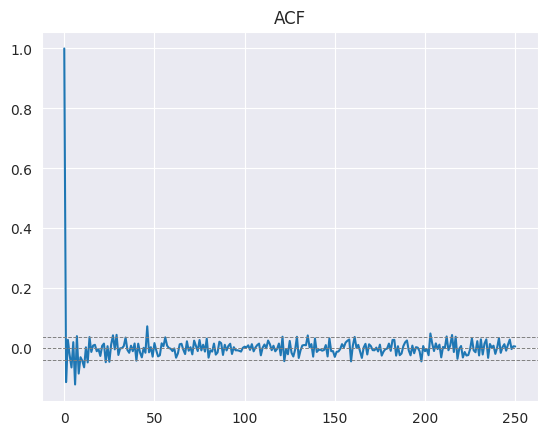

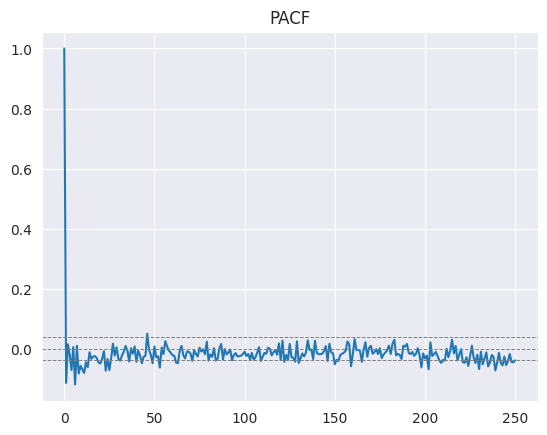

In [ ]:
# Plotando as curvas com grau de tolerância de 5%
plt.plot(lag_acf)

plt.axhline(y= -1.96/(np.sqrt((len(df_diff) -1))), linestyle='--', color='gray',linewidth=0.7)
plt.axhline(y=0, linestyle='--', color='gray',linewidth=0.7)
plt.axhline(y= 1.96/(np.sqrt((len(df_diff) -1))), linestyle='--', color='gray',linewidth=0.7)

plt.title("ACF")
plt.show()

plt.plot(lag_pacf)

plt.axhline(y= -1.96/(np.sqrt((len(df_diff) -1))), linestyle='--', color='gray',linewidth=0.7)
plt.axhline(y=0, linestyle='--', color='gray',linewidth=0.7)
plt.axhline(y= 1.96/(np.sqrt((len(df_diff) -1))), linestyle='--', color='gray',linewidth=0.7)

plt.title("PACF")
plt.show()


Os limites não estão muito fáceis de serem analisados dentro desse nlags, então, vamos testar com outro número de intervalos:

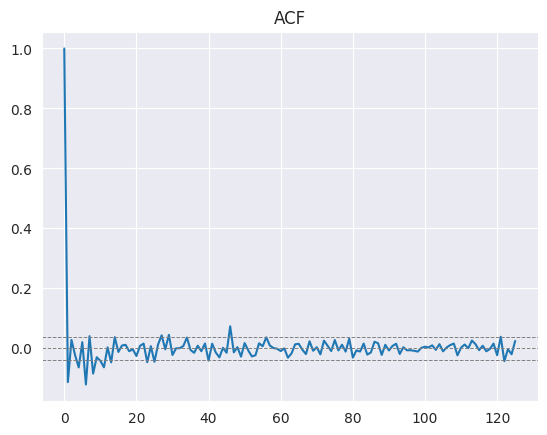

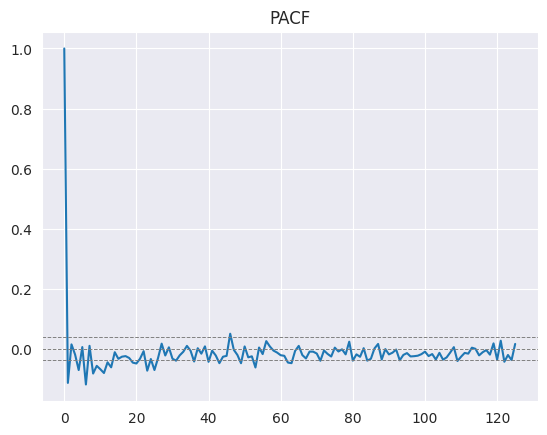

In [ ]:
# Plotando as curvas no 2º teste
lag_acf = acf(df_diff.dropna(), nlags=125) # Testando com 6 meses em dias úteis
lag_pacf = pacf(df_diff.dropna(), nlags=125)

plt.plot(lag_acf)

plt.axhline(y= -1.96/(np.sqrt((len(df_diff) -1))), linestyle='--', color='gray',linewidth=0.7)
plt.axhline(y=0, linestyle='--', color='gray',linewidth=0.7)
plt.axhline(y= 1.96/(np.sqrt((len(df_diff) -1))), linestyle='--', color='gray',linewidth=0.7)

plt.title("ACF")
plt.show()

plt.plot(lag_pacf)

plt.axhline(y= -1.96/(np.sqrt((len(df_diff) -1))), linestyle='--', color='gray',linewidth=0.7)
plt.axhline(y=0, linestyle='--', color='gray',linewidth=0.7)
plt.axhline(y= 1.96/(np.sqrt((len(df_diff) -1))), linestyle='--', color='gray',linewidth=0.7)

plt.title("PACF")
plt.show()

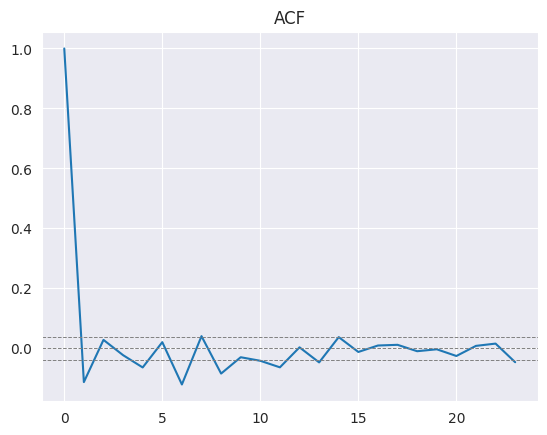

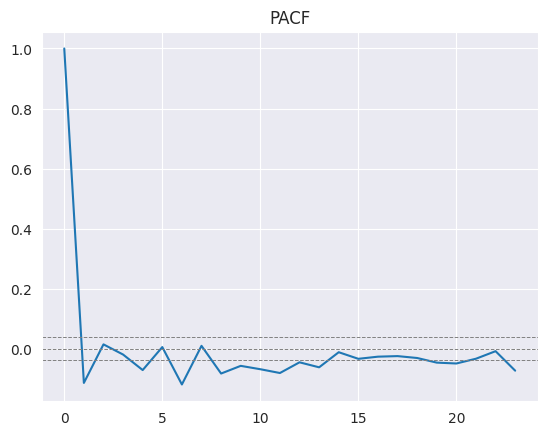

In [ ]:
# Plotando as curvas no 3º teste
lag_acf = acf(df_diff.dropna(), nlags=23) # Testando com 1 mês em dias úteis
lag_pacf = pacf(df_diff.dropna(), nlags=23)

plt.plot(lag_acf)

plt.axhline(y= -1.96/(np.sqrt((len(df_diff) -1))), linestyle='--', color='gray',linewidth=0.7)
plt.axhline(y=0, linestyle='--', color='gray',linewidth=0.7)
plt.axhline(y= 1.96/(np.sqrt((len(df_diff) -1))), linestyle='--', color='gray',linewidth=0.7)

plt.title("ACF")
plt.show()

plt.plot(lag_pacf)

plt.axhline(y= -1.96/(np.sqrt((len(df_diff) -1))), linestyle='--', color='gray',linewidth=0.7)
plt.axhline(y=0, linestyle='--', color='gray',linewidth=0.7)
plt.axhline(y= 1.96/(np.sqrt((len(df_diff) -1))), linestyle='--', color='gray',linewidth=0.7)

plt.title("PACF")
plt.show()

Agora sim ficou mais fácil pra analisar e identificar os parâmetros do ARIMA. A partir do gráfico ACF, vemos que o eixo y é crzado pela primeira vez no x=1 (q=1). E do gráfico PACF, vemos que a curva cruza no x = 1 (p=1).

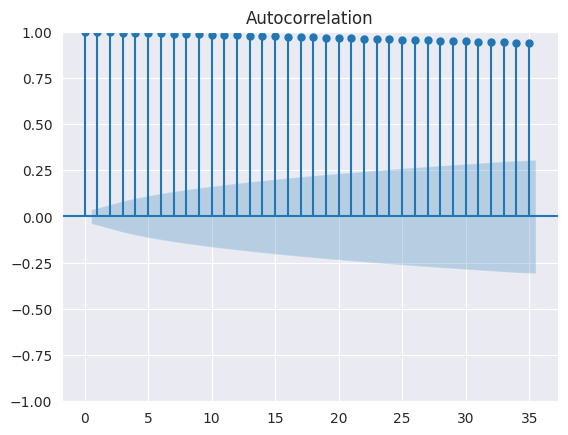

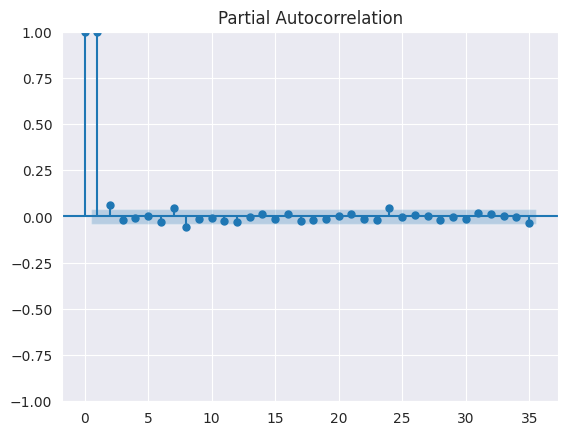

In [ ]:
# Visualizando por outro método de ACF e PACF, usando a biblioteca do Statsmodel
plot_acf(df.ultimo)
plot_pacf(df.ultimo)
plt.show()

Portanto, a autocorrelação nos diz o quanto um período está correlacionado com outro e a autocorrelação parcial pela correlação direta.

## Modelagem e Avaliação

Agora, vamos começar a etapa de modelagem usando a biblioteca Statsforecast nos modelos Naive, SeasonalNaive, SeasonalWindowAverage e AutoARIMA. Antes, vamos adequar o formato do dataframe pra poder ser utilizado na biblioteca:


Preciso de um dataframe com 3 colunas: unique_id, ds e y. Por isso, vou criar um coluna unique_id arbitrária



In [ ]:
df

,data,ultimo,abertura,maxima,minima,volume,variacao
Data,,,,,,,
2023-08-30,30.08.2023,117.535,118.404,118.841,117.471,8920000.0,-0.73
2023-08-29,29.08.2023,118.404,118.051,118.493,117.400,9630000.0,1.10
2023-08-28,28.08.2023,117.121,115.838,117.253,115.836,9600000.0,1.11
2023-08-25,25.08.2023,115.837,117.025,117.252,115.397,9210000.0,-1.02
2023-08-24,24.08.2023,117.026,118.135,118.136,116.848,9200000.0,-0.94
...,...,...,...,...,...,...,...
2013-01-08,08.01.2013,61.128,61.933,62.265,61.081,3840000.0,-1.30
2013-01-07,07.01.2013,61.933,62.523,62.699,61.639,3990000.0,-0.94
2013-01-04,04.01.2013,62.523,63.314,63.314,62.415,6230000.0,-1.25


In [ ]:
# Excluindo colunas desnecessárias
df = df.drop(columns=['abertura', 'maxima','minima', 'volume','variacao'])

# Formatando coluna de data
df['data'] = pd.to_datetime(df.data, format = '%d.%m.%Y')

# Criando coluna unique_id como um valor único categórico e arbitrário
df['unique_id'] = 'Valor'


# Renomeando colunas
df= df.rename(columns={'data':'ds','ultimo':'y'})


In [ ]:
df.head()

,ds,y,unique_id
Data,,,
2023-08-30,2023-08-30,117.535,Valor
2023-08-29,2023-08-29,118.404,Valor
2023-08-28,2023-08-28,117.121,Valor
2023-08-25,2023-08-25,115.837,Valor
2023-08-24,2023-08-24,117.026,Valor


In [ ]:
# Recortando o dataframe e usando o primeiro ano pra treino
treino = df.loc[df['ds'] < '2014-01-01']
valid = df.loc[(df['ds'] >= '2014-01-01') & (df['ds'] < '2014-05-15')]
h = valid['ds'].nunique()

In [ ]:
h


90

O horizonte de predição será de 90 dias úteis, 4 meses e meio, no caso da série temporal que estamos analisando. Trabalhar com validação curta é importante pra lidar com uma menor largura de banda, um menor erro.


Vamos trabalhar com um método de validação com uma variação do erro percentual médio usando o módulo do MAPE.

In [ ]:
def wmape(y_true, y_pred):
  return np.abs(y_true-y_pred).sum() / np.abs(y_true).sum()

Agora vamos plotar o modelo:

WMAPE: nan%


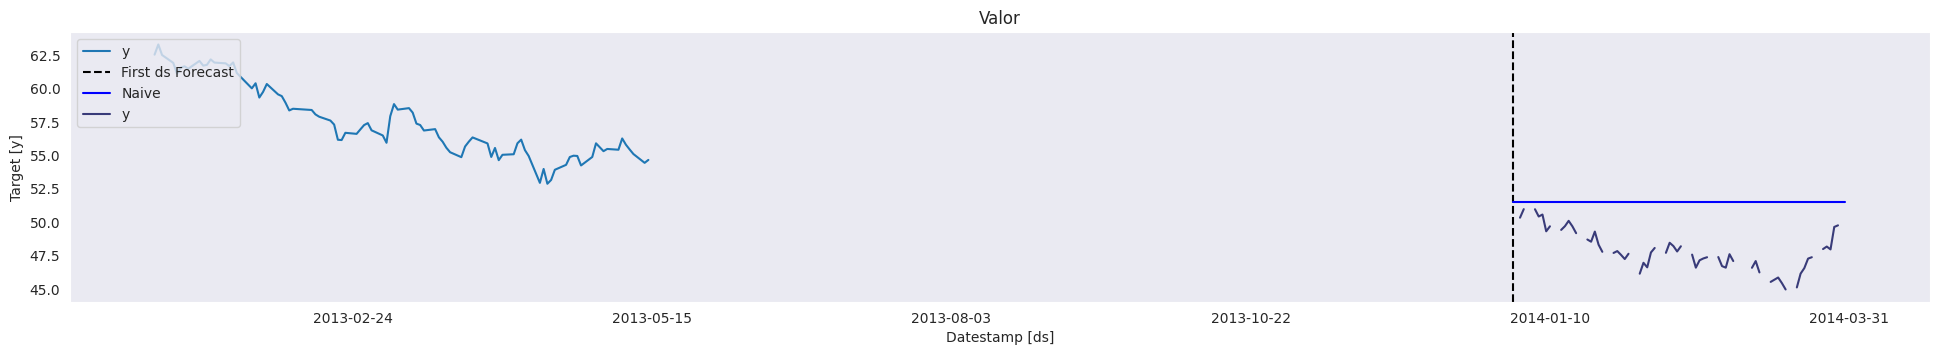

In [ ]:
# Criando o modelo a partir do modelo baseline Naive na solução trivial
model_n = StatsForecast (models=[Naive()], freq='D', n_jobs=-1)
model_n.fit(treino)

forecast_df = model_n.predict(h=h)
forecast_df = forecast_df.reset_index().merge(valid, on=['ds', 'unique_id'], how='left')

wmape1 = wmape(forecast_df['y'].values, forecast_df['Naive'].values)
print(f"WMAPE: {wmape1:.2%}")

model_n.plot(treino, forecast_df, level=[90], unique_ids=['Valor'],engine ='matplotlib', max_insample_length=90)


In [ ]:
#Aplicando o modelo AR+I+MA
model = ARIMA(df_s, order=(1,1,1)) #(p,d,q)
model_fit = model.fit(disp=0)
print(model_fit.summary())



NotImplementedError: ignored

WMAPE: nan%


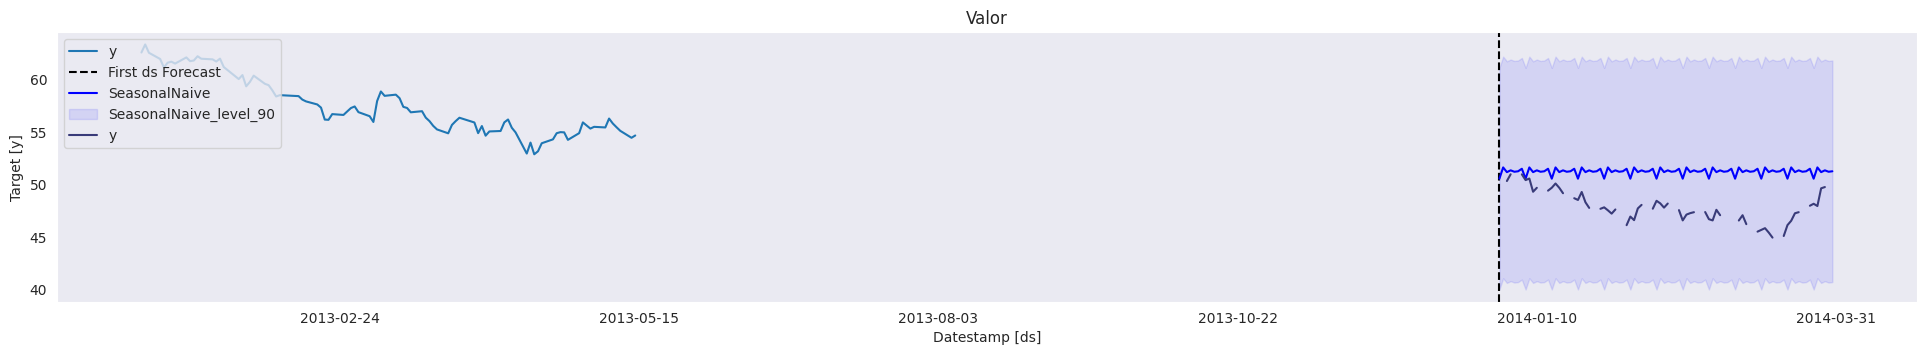

In [ ]:
model_s = StatsForecast(models=[SeasonalNaive(season_length=7)], freq='D', n_jobs=-1)
model_s.fit(treino)

forecast_dfs = model_s.predict(h=h, level=[90])
forecast_dfs = forecast_dfs.reset_index().merge(valid, on=['ds', 'unique_id'], how='left')

wmape2 = wmape(forecast_dfs['y'].values, forecast_dfs['SeasonalNaive'].values)
print(f"WMAPE: {wmape2:.2%}")

model_s.plot(treino, forecast_dfs, level=[90], unique_ids=['Valor'],engine ='matplotlib', max_insample_length=90)

WMAPE: nan%


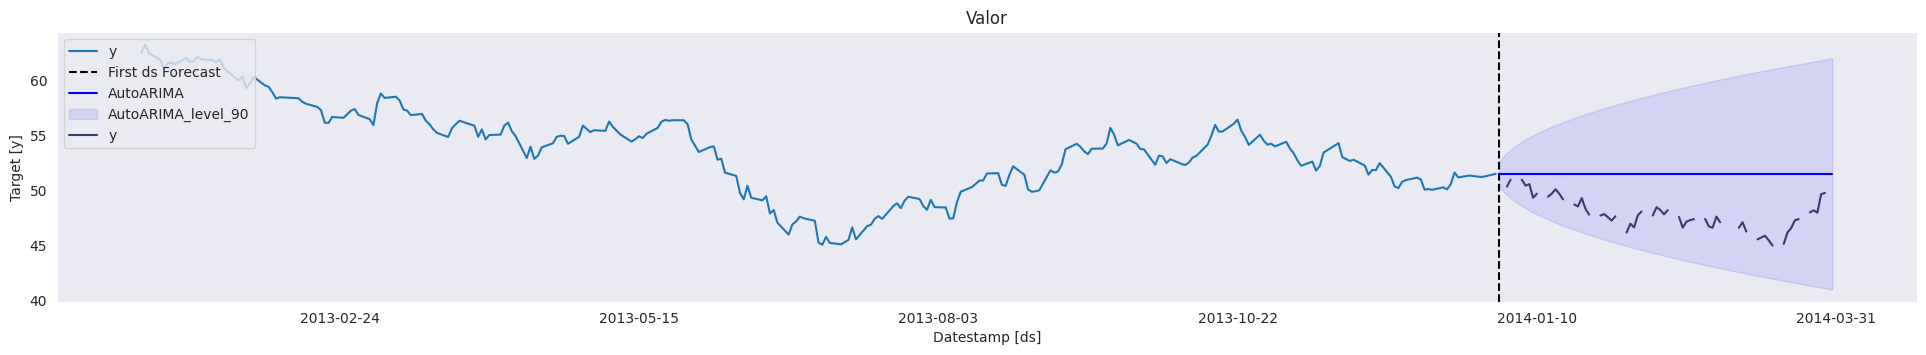

In [ ]:
model_a = StatsForecast (models=[AutoARIMA (season_length=30)], freq='D', n_jobs=-1)
model_a.fit(treino)
forecast_autorima = model_a.predict(h=h, level=[90])
forecast_autorima = forecast_autorima.reset_index(). merge(valid, on=['ds', 'unique_id'], how='left')
wmape4 = wmape(forecast_autorima['y'].values, forecast_autorima['AutoARIMA'].values)
print(f"WMAPE: {wmape4:.2%}")
model_a.plot(treino, forecast_autorima, level=[90], unique_ids=['Valor'], engine ='matplotlib')

In [ ]:
forecast_autorima

,unique_id,ds,AutoARIMA,AutoARIMA-lo-90,AutoARIMA-hi-90,y
0,Valor,2013-12-31,51.507,50.395321,52.618679,NaN
1,Valor,2014-01-01,51.507,49.934845,53.079155,NaN
2,Valor,2014-01-02,51.507,49.581512,53.432487,50.341
3,Valor,2014-01-03,51.507,49.283638,53.730362,50.981
4,Valor,2014-01-04,51.507,49.021206,53.992794,NaN
...,...,...,...,...,...,...
85,Valor,2014-03-26,51.507,41.197697,61.816303,47.966
86,Valor,2014-03-27,51.507,41.137932,61.876068,49.647
87,Valor,2014-03-28,51.507,41.078510,61.935490,49.768
88,Valor,2014-03-29,51.507,41.019424,61.994576,NaN


WMAPE: nan%


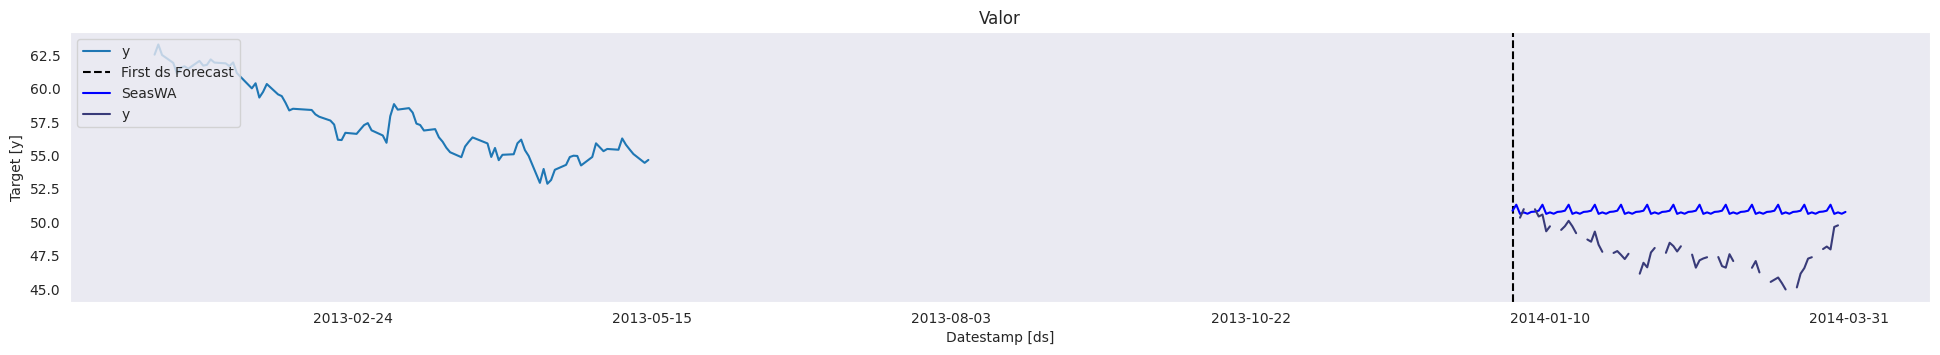

In [ ]:
model_sm = StatsForecast(models=[SeasonalWindowAverage(season_length=7, window_size=2)], freq='D', n_jobs=-1)
model_sm.fit(treino)

forecast_dfsm = model_sm.predict(h=h)
forecast_dfsm = forecast_dfsm.reset_index().merge(valid, on=['ds', 'unique_id'], how='left')

wmape3 = wmape(forecast_dfsm['y'].values, forecast_dfsm['SeasWA'].values)
print(f"WMAPE: {wmape3:.2%}")

model_sm.plot(treino, forecast_dfsm, level=[90], unique_ids=['Valor'],engine ='matplotlib', max_insample_length=90)

WMAPE: nan%


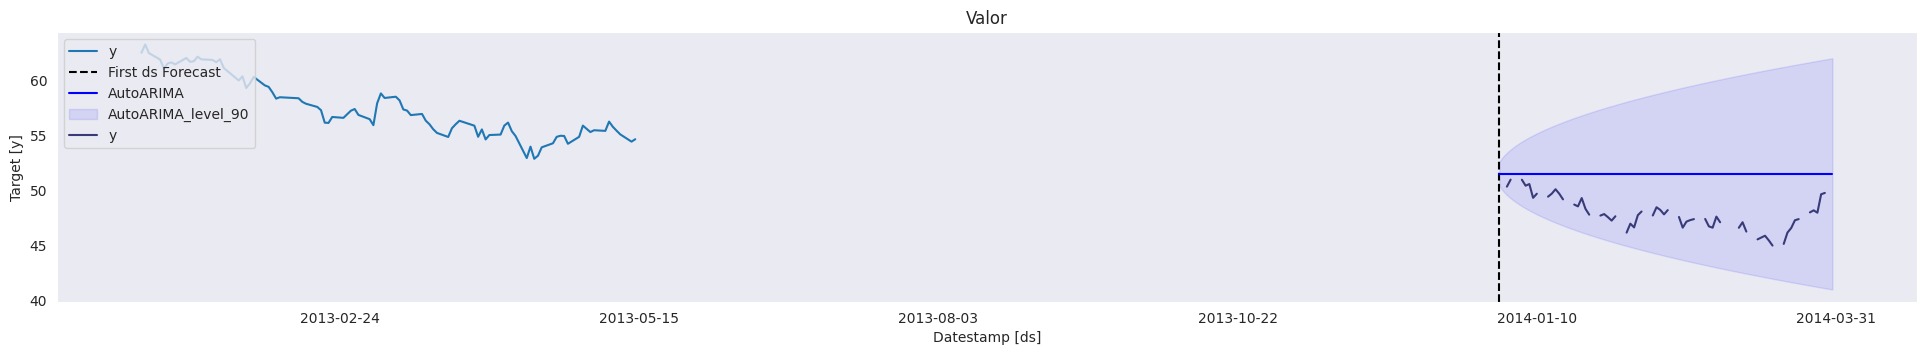

In [ ]:
model_a = StatsForecast(models=[AutoARIMA(season_length=7)], freq='D', n_jobs=-1)
model_a.fit(treino)

forecast_dfa = model_a.predict(h=h, level=[90])
forecast_dfa = forecast_dfa.reset_index().merge(valid, on=['ds', 'unique_id'], how='left')

wmape4 = wmape(forecast_dfa['y'].values, forecast_dfa['AutoARIMA'].values)
print(f"WMAPE: {wmape4:.2%}")

model_a.plot(treino, forecast_dfa, level=[90], unique_ids=['Valor'],engine ='matplotlib', max_insample_length=90)